The problem is to predict if a project on donorschoose will not get fully funded within 60 days of posting. 
* This prediction is being done at the time of posting so you can only use data available to you at that time. 
* The data is a file that has one row for each project posted with a column for "date_posted" (the date the project was posted) and a column for "datefullyfunded" (the date the project was fully funded - assumption for this assignment is that all projects were fully funded eventually). 
* The data spans Jan 1, 2012 to Dec 31, 2013. 
* You should have your validation/test set be a rolling window of 6 months (which should give you three test sets). 
* The training sets should be everything from 1/1/12 to the beginning of the test set.

In [44]:
# basic dependencies
import datetime
import numpy as np
import pandas as pd 
import seaborn as sns
import plotnine as p9
import matplotlib.pyplot as plt
from sklearn import preprocessing

# my own library of useful functions
import utils
import exploration as exp
import pipeline as pipe

In [45]:
projraw = utils.read_data('projects_2012_2013', 'csv')

In [46]:
projraw.head()

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_metro,school_district,...,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded
0,00001ccc0e81598c4bd86bacb94d7acb,96963218e74e10c3764a5cfb153e6fea,9f3f9f2c2da7edda5648ccd10554ed8c,1.709930e+11,41.807654,-87.673257,Chicago,IL,urban,Pershing Elem Network,...,Visual Arts,Music & The Arts,Supplies,highest poverty,Grades PreK-2,1498.61,31.0,f,4/14/13,5/2/13
1,0000fa3aa8f6649abab23615b546016d,2a578595fe351e7fce057e048c409b18,3432ed3d4466fac2f2ead83ab354e333,6.409801e+10,34.296596,-119.296596,Ventura,CA,urban,Ventura Unif School District,...,Literature & Writing,Literacy & Language,Books,highest poverty,Grades 3-5,282.47,28.0,t,4/7/12,4/18/12
2,000134f07d4b30140d63262c871748ff,26bd60377bdbffb53a644a16c5308e82,dc8dcb501c3b2bb0b10e9c6ee2cd8afd,6.227100e+10,34.078625,-118.257834,Los Angeles,CA,urban,Los Angeles Unif Sch Dist,...,Social Sciences,History & Civics,Technology,high poverty,Grades 3-5,1012.38,56.0,f,1/30/12,4/15/12
3,0001f2d0b3827bba67cdbeaa248b832d,15d900805d9d716c051c671827109f45,8bea7e8c6e4279fca6276128db89292e,3.600090e+11,40.687286,-73.988217,Brooklyn,NY,urban,New York City Dept Of Ed,...,NaN,NaN,Books,high poverty,Grades PreK-2,175.33,23.0,f,10/11/12,12/5/12
4,0004536db996ba697ca72c9e058bfe69,400f8b82bb0143f6a40b217a517fe311,fbdefab6fe41e12c55886c610c110753,3.606870e+11,40.793018,-73.205635,Central Islip,NY,suburban,Central Islip Union Free SD,...,Literature & Writing,Literacy & Language,Technology,high poverty,Grades PreK-2,3591.11,150.0,f,1/8/13,3/25/13


In [47]:
utils.find_cols_with_missing(projraw)

school_ncesid               9233
school_metro               15224
school_district              172
primary_focus_subject         15
primary_focus_area            15
secondary_focus_subject    40556
secondary_focus_area       40556
resource_type                 17
grade_level                    3
students_reached              59
dtype: int64

In [48]:
projraw.info()
# results of this make me want to not include secondary focus subject or area as a feature.
# Create boolean features for is_subject... etc. Then I can include nans. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124976 entries, 0 to 124975
Data columns (total 26 columns):
projectid                                 124976 non-null object
teacher_acctid                            124976 non-null object
schoolid                                  124976 non-null object
school_ncesid                             115743 non-null float64
school_latitude                           124976 non-null float64
school_longitude                          124976 non-null float64
school_city                               124976 non-null object
school_state                              124976 non-null object
school_metro                              109752 non-null object
school_district                           124804 non-null object
school_county                             124976 non-null object
school_charter                            124976 non-null object
school_magnet                             124976 non-null object
teacher_prefix                           

Here's what I'm going to do to this dataframe:
* convert date columns to dates
* convert t/f columns to actual booleans
* take the categorical variables and convert them to binary
* what should I normalize??? probably price, students reached

In [52]:
# convert categorical variables to binary
categorical_list = ['school_state',
                    'school_metro',
                    'primary_focus_subject',
                    'primary_focus_area',
                    'secondary_focus_subject',
                    'secondary_focus_area', 
                    'resource_type', 
                    'poverty_level',
                    'grade_level']
proj = utils.make_cat_dummy(projraw, categorical_list)

# create major city dummy for biggest cities
big_cities = ['Los Angeles', 'Chicago', 'Houston', 'Brooklyn', 'Bronx', 'New York']
proj['in_big_city'] = np.where(proj['school_city'].isin(big_cities), 1, 0)

# create dummies for female teacher and teacher with doctorate
proj['teacher_is_female'] = np.where(proj['teacher_prefix'].isin(['Mrs.', 'Ms.']), True, False)
proj['teacher_is_dr'] = np.where(proj['teacher_prefix'] == 'Dr.', True, False)

# replace string true/false with boolean values
proj = utils.convert_to_boolean(proj, ['school_charter',
                                       'school_magnet',
                                      'eligible_double_your_impact_match'], 't', 'f')

# convert date fields and compute whether project is funded within 60 days
proj['date_posted'] = pd.to_datetime(proj.date_posted) 
proj['datefullyfunded'] = pd.to_datetime(proj.datefullyfunded)
proj['funded'] = np.where(proj.datefullyfunded - proj.date_posted <= datetime.timedelta(days=60), 1, 0)

# normalize project price and students reached
proj['total_price_norm'] = preprocessing.scale(proj['total_price_including_optional_support'].astype('float64'))
proj['students_reached_norm'] = preprocessing.scale(proj['students_reached'].astype('float64'))

In [55]:
not_feature_cols = ['teacher_acctid',
                  'schoolid',
                  'school_ncesid',
                  'school_latitude', 
                  'school_longitude',
                  'school_district',
                  'school_county',
                  'teacher_prefix',
                   'date_posted',
                   'datefullyfunded',
                   'funded']
features = list(set(proj.columns).difference(not_feature_cols))
features

['poverty_level_low poverty',
 'primary_focus_subject_Literacy',
 'school_state_MT',
 'secondary_focus_subject_Health & Life Science',
 'school_state_DC',
 'school_charter',
 'primary_focus_area_Health & Sports',
 'school_state_CA',
 'resource_type_Technology',
 'school_state_KS',
 'school_state_KY',
 'secondary_focus_subject_Literature & Writing',
 'primary_focus_subject_Early Development',
 'primary_focus_subject_Parent Involvement',
 'total_price_norm',
 'school_metro_suburban',
 'secondary_focus_subject_Nutrition',
 'school_state_NJ',
 'secondary_focus_subject_Visual Arts',
 'grade_level_Grades 9-12',
 'primary_focus_area_History & Civics',
 'school_metro_urban',
 'resource_type_Books',
 'primary_focus_subject_Civics & Government',
 'school_state_MN',
 'secondary_focus_subject_Sports',
 'school_state_MS',
 'school_state_OR',
 'primary_focus_subject_Special Needs',
 'school_state_PA',
 'grade_level_Grades 3-5',
 'school_state_FL',
 'school_state_nan',
 'secondary_focus_area_nan',
 '

/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


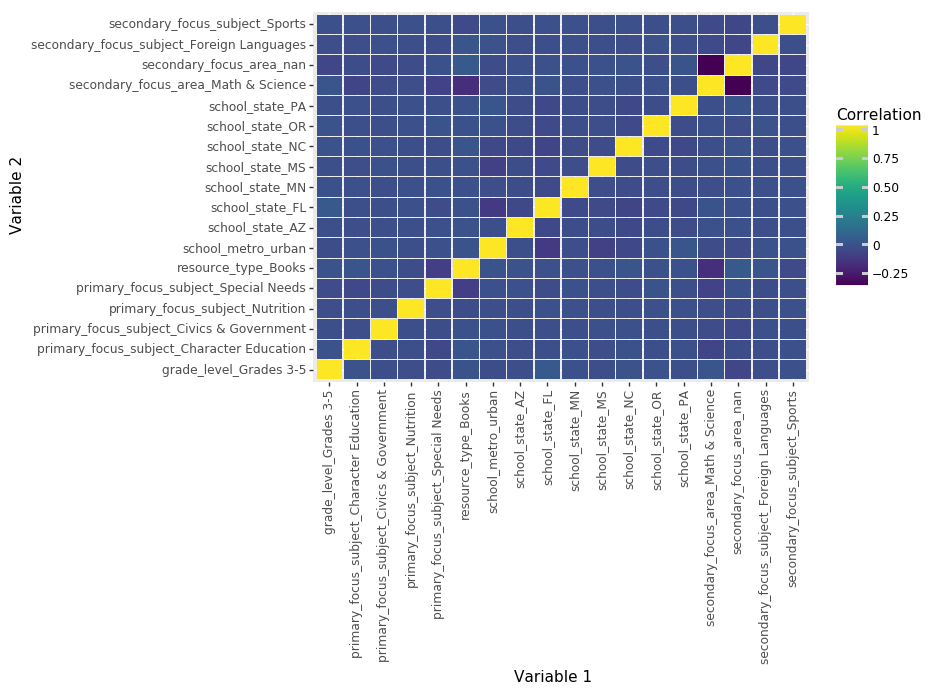

<ggplot: (7554497074)>

In [58]:
exp.plot_correlations(proj, features[21:40])

In [28]:
projraw.groupby('school_state').count().reset_index().sort_values(by='projectid', ascending=False)

,school_state,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_metro,school_district,...,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,date_posted,datefullyfunded
4,CA,29227,29227,29227,27655,29227,29227,29227,27492,29196,...,20682,20682,29222,29227,29226,29227,29219,29227,29227,29227
34,NY,9512,9512,9512,8512,9512,9512,9512,8836,9511,...,6730,6730,9511,9512,9512,9512,9504,9512,9512,9512
43,TX,8938,8938,8938,7943,8938,8938,8938,8060,8867,...,6088,6088,8937,8938,8938,8938,8931,8938,8938,8938
9,FL,6715,6715,6715,6486,6715,6715,6715,5835,6715,...,4514,4514,6714,6715,6715,6715,6713,6715,6715,6715
14,IL,5535,5535,5535,5095,5535,5535,5535,5127,5530,...,3658,3658,5534,5535,5535,5535,5529,5535,5535,5535
27,NC,5447,5447,5447,4984,5447,5447,5447,4331,5428,...,3544,3544,5447,5447,5447,5447,5444,5447,5447,5447
10,GA,3863,3863,3863,3696,3863,3863,3863,3368,3863,...,2607,2607,3863,3863,3862,3863,3862,3863,3863,3863
38,PA,2723,2723,2723,2555,2723,2723,2723,2476,2722,...,1707,1707,2723,2723,2723,2723,2721,2723,2723,2723
40,SC,2601,2601,2601,2477,2601,2601,2601,1994,2601,...,1687,1687,2601,2601,2601,2601,2598,2601,2601,2601
15,IN,2587,2587,2587,2236,2587,2587,2587,2170,2572,...,1578,1578,2587,2587,2587,2587,2584,2587,2587,2587


In [30]:
proj.teacher_prefix.unique()

array(['Mrs.', 'Ms.', 'Mr.', 'Dr.'], dtype=object)